In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from keras import models
from keras import layers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from keras.applications.xception import Xception
from keras.applications import VGG16
from keras.applications import NASNetLarge
from keras.models import Model
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing import image
import os, shutil

Using TensorFlow backend.


In [2]:
bread_labels = pd.read_csv('../pet_data/breed_labels.csv')
color_labels = pd.read_csv('../pet_data/color_labels.csv')
state_labels = pd.read_csv('../pet_data/state_labels.csv')
test_sample_submission = pd.read_csv('../pet_data/test/sample_submission.csv')
test = pd.read_csv('../pet_data/test/test.csv')
train = pd.read_csv('../pet_data/train.csv')
train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])
train_folder = '../pet_data/train_images/'
test_folder = '../pet_data/test_images/'

/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [3]:
train_images = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_images = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

In [4]:
train_images.sort()
test_images.sort()
train_images

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [5]:
train['Animal'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

In [6]:
pet_id_adopt_rate = pd.DataFrame([train.PetID, train.AdoptionSpeed, train.Type, train.Animal]).transpose()

In [7]:
pet_id_adopt_rate

,PetID,AdoptionSpeed,Type,Animal
0,86e1089a3,2,2,Cat
1,6296e909a,0,2,Cat
2,3422e4906,3,1,Dog
3,5842f1ff5,2,1,Dog
4,850a43f90,2,1,Dog
5,d24c30b4b,2,2,Cat
6,1caa6fcdb,1,2,Cat
7,97aa9eeac,3,1,Dog
8,c06d167ca,1,2,Cat
9,7a0942d61,4,2,Cat


In [8]:
image_names = []

for image_name in os.listdir('../pet_data/train_images/'):
    image_names.append(image_name)

In [9]:
image_names_df = pd.DataFrame(image_names, columns=['image_name'])
image_names_df.sort_values(by=['image_name'], ascending=True)

,image_name
4500,0008c5398-1.jpg
3162,0008c5398-5.jpg
60,000fb9572-1.jpg
1259,000fb9572-3.jpg
9764,0011d7c25-1.jpg
234,00156db4a-5.jpg
376,001a1aaad-1.jpg
8083,001b1507c-2.jpg
8153,001b1507c-3.jpg
9413,002278114-10.jpg


In [10]:
image_ids = []

for image_id in image_names_df.image_name:
    image_ids.append(image_id[:image_id.index('-')])
    

# image_ids = set(image_ids)
image_ids = list(image_ids)
image_ids.sort()
len(image_ids)

10331

In [11]:
image_names_dataf = pd.DataFrame(image_ids, columns=['PetID'])
image_names_dataf.describe()

,PetID
count,10331
unique,6833
top,be579e6ed
freq,10


In [12]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    

# image_ids = set(image_ids)
# image_ids2 = list(image_ids)
image_ids2.sort()
image_ids2

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [13]:
merged_images = pd.merge(image_names_dataf, pet_id_adopt_rate, on=['PetID'], how='inner')
merged_images.sort_values('PetID')
merged_images.loc[merged_images['PetID'] == '0008c5398']

,PetID,AdoptionSpeed,Type,Animal
0,0008c5398,3,2,Cat
1,0008c5398,3,2,Cat


In [14]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    

# image_ids = set(image_ids)
# image_ids2 = list(image_ids)
image_ids2.sort()
image_ids2

['0008c5398-1.jpg',
 '0008c5398-5.jpg',
 '000fb9572-1.jpg',
 '000fb9572-3.jpg',
 '0011d7c25-1.jpg',
 '00156db4a-5.jpg',
 '001a1aaad-1.jpg',
 '001b1507c-2.jpg',
 '001b1507c-3.jpg',
 '002278114-10.jpg',
 '002278114-4.jpg',
 '002278114-7.jpg',
 '0038234c6-3.jpg',
 '004a26127-1.jpg',
 '0052dcf47-1.jpg',
 '00553ae55-4.jpg',
 '005afe792-10.jpg',
 '005afe792-9.jpg',
 '00648f96f-2.jpg',
 '006d301e9-1.jpg',
 '00709d75b-3.jpg',
 '007bc1db4-4.jpg',
 '007ffeccd-1.jpg',
 '007ffeccd-7.jpg',
 '007ffeccd-8.jpg',
 '00904fc2c-2.jpg',
 '0090eb457-1.jpg',
 '00a1f270a-1.jpg',
 '00af25fc0-2.jpg',
 '00b23513e-4.jpg',
 '00be0a63e-3.jpg',
 '00c19f4fa-1.jpg',
 '00e50c7a7-1.jpg',
 '00e50c7a7-2.jpg',
 '00eca0391-5.jpg',
 '00eced1f0-1.jpg',
 '010a59236-11.jpg',
 '010a59236-12.jpg',
 '010a59236-14.jpg',
 '010a59236-16.jpg',
 '010a59236-18.jpg',
 '010a59236-19.jpg',
 '010a59236-2.jpg',
 '010a59236-4.jpg',
 '01231c438-5.jpg',
 '012a1a396-10.jpg',
 '012a1a396-4.jpg',
 '0133b2a29-3.jpg',
 '0142670c8-2.jpg',
 '0149d04e7

In [15]:
merged_images.PetID = image_ids2
merged_images

,PetID,AdoptionSpeed,Type,Animal
0,0008c5398-1.jpg,3,2,Cat
1,0008c5398-5.jpg,3,2,Cat
2,000fb9572-1.jpg,3,1,Dog
3,000fb9572-3.jpg,3,1,Dog
4,0011d7c25-1.jpg,2,2,Cat
5,00156db4a-5.jpg,1,1,Dog
6,001a1aaad-1.jpg,2,2,Cat
7,001b1507c-2.jpg,1,2,Cat
8,001b1507c-3.jpg,1,2,Cat
9,002278114-10.jpg,1,2,Cat


In [16]:
generator_dict = {'filename': [], 'class': [], 'type': []}

for img in train_images:
    generator_dict['filename'].append(img)
for label in merged_images.AdoptionSpeed:
    generator_dict['class'].append(str(label))
for label_type in merged_images.Type:
    generator_dict['type'].append(str(label_type))

generator_df = pd.DataFrame(generator_dict)
generator_df.head(8)

,filename,class,type
0,0008c5398-1.jpg,3,2
1,0008c5398-5.jpg,3,2
2,000fb9572-1.jpg,3,1
3,000fb9572-3.jpg,3,1
4,0011d7c25-1.jpg,2,2
5,00156db4a-5.jpg,1,1
6,001a1aaad-1.jpg,2,2
7,001b1507c-2.jpg,1,2


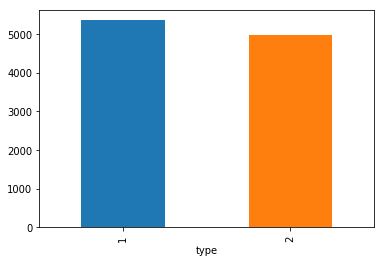

In [17]:
generator_df.groupby('type').size().plot.bar()
generator_df = generator_df.drop(['class'], axis=1)

In [18]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(generator_df, test_size=0.2)

In [19]:

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

Found 6198 validated image filenames belonging to 2 classes.
Found 2066 validated image filenames belonging to 2 classes.
Found 2067 validated image filenames belonging to 2 classes.


In [20]:
model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                         input_shape=(224, 224, 3)))

# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(2, activation='softmax'))


model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(150, 150, 3), activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,..., activation="relu", padding="same")`
/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/Users/darrenmoriarty/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), act

In [21]:
# model.compile(loss='categorical_crossentropy',
#                       optimizer='Adam',
#                       metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=0.0001),
metrics=['accuracy'])

In [24]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
    callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/50
  7/387 [..............................] - ETA: 10:41 - loss: 0.6996 - acc: 0.5179

Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/d

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('model accuracy')
plt.xlabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('model loss')
plt.xlabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss_and_metrics = model.evaluate_generator(test_generator, STEP_SIZE_TEST)

In [86]:
loss_and_metrics

[1.9710587086219182, 0.7684108527131783]

In [87]:
test_generator.reset()
y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
y_pred

129/129 [==============================] - 9s 67ms/step


array([[7.0395768e-03],
       [3.5762787e-06],
       [7.0243609e-01],
       ...,
       [2.0861626e-07],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [88]:
predicted_class_indices = np.argmax(y_pred, axis=1)

In [89]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [93]:
len(filenames)
len(predictions)

2064

In [94]:
filenames = test_generator.filenames[0:2064]
results = pd.DataFrame({'Filename': filenames, 'Predictions' :predictions})
results

,Filename,Predictions
0,02f31f1ba-4.jpg,1
1,b5974bdd0-7.jpg,1
2,ab4ef2577-5.jpg,1
3,8cd96bf75-2.jpg,1
4,072ae6d9e-1.jpg,1
5,621b83ac7-12.jpg,1
6,8cc02d983-1.jpg,1
7,52da0c86c-3.jpg,1
8,de1a20009-12.jpg,1
9,f08b9d3c3-4.jpg,1


In [97]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(test_generator.labels[0:2064], y_pred.argmax(axis=1))

In [98]:
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print('normalized confusion matrix')
    else:
        print('unnormalized confusion matrix')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black'
                )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [99]:
my_labels = ['0', '1']

In [42]:
import itertools 
plot_confusion_matrix(c_matrix, my_labels)

NameError: name 'plot_confusion_matrix' is not defined

# VGG-16


In [41]:
vgg16_model = VGG16()

In [28]:
from keras.models import Sequential

model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [30]:
model.layers.pop()

In [31]:
for layer in model.layers:
    layer.trainable = False

In [33]:
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(224, 224), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(224, 224), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=1,
#     callbacks=[checkpoint],
    validation_data=valid_generator,
    use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Found 6198 validated image filenames belonging to 2 classes.
Found 2066 validated image filenames belonging to 2 classes.
Found 2067 validated image filenames belonging to 2 classes.
Epoch 1/1
  7/387 [..............................] - ETA: 29:38 - loss: 0.6921 - acc: 0.5893

Process ForkPoolWorker-14:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-16:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*se

KeyboardInterrupt: 

  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
KeyboardInterrupt
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/Users/darrenmoriarty/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_b